# L1: Overview of Multimodality

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

* In this classroom, the libraries have been already installed for you.
* If you would like to run this code on your own machine, you need to install the following:
```
    !pip install -q accelerate torch
    !pip install -U scikit-learn
    !pip install umap-learn
    !pip install tqdm
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [2]:
# Import neural network training libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Import basic computation libraries along with data visualization and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# Import our data class which will organize MNIST and provide anchor, positive and negative samples.
from mnist_dataset import MNISTDataset

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Utils File and Helper Functions:</b> To access the <code>mnist_dataset.py</code> and other files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


## Load MNIST Dataset

In [3]:
# Load data from csv
data = pd.read_csv('digit-recognizer/train.csv')
val_count = 1000
# common transformation for both val and train
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Split data into val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)

100%|██████████| 1000/1000 [00:00<00:00, 6149.00it/s]


## Setup our DataLoaders

In [4]:
# Create torch dataloaders
trainLoader = DataLoader(
    dataset,
    batch_size=16, # feel free to modify this value
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

valLoader = DataLoader(val_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

### Visualize datapoints

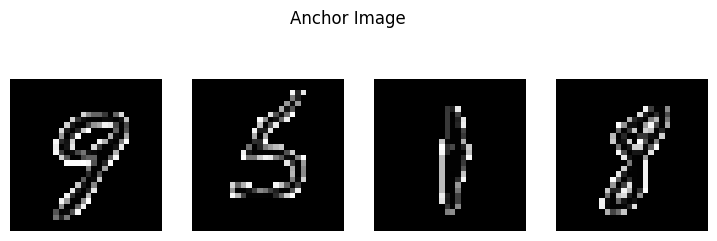

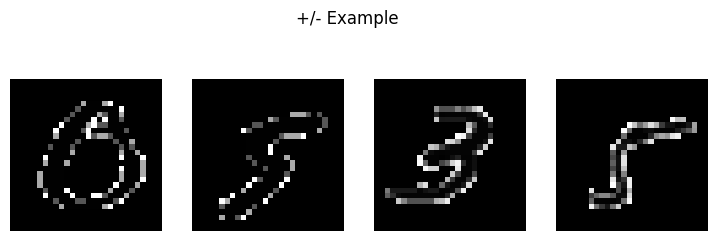

In [5]:
# Function to display images with labels
def show_images(images, title=''):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(9, 3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Visualize some examples
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
    # Convert tensors to numpy arrays
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()
    
    # Display some samples from the batch
    show_images(anchor_images[:4], title='Anchor Image')
    show_images(contrastive_images[:4], title='+/- Example')
    
    # Break after displaying one batch for demonstration
    break


> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern.

## Build Neural Network Architecture

In [6]:
# Define a neural network architecture with two convolution layers and two fully connected layers
# Input to the network is an MNIST image and Output is a 64 dimensional representation. 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
        )

    def forward(self, x):
        x = self.conv1(x) # x: d * 32 * 12 * 12
        x = self.conv2(x) # x: d * 64 * 4  * 4 
        x = x.view(x.size(0), -1) # x: d * (64*4*4)
        x = self.linear1(x) # x: d * 64
        return x

## Contrastive Loss Function

In [7]:
# The ideal distance metric for a positive sample is set to 1, for a negative sample it is set to 0      
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, anchor, contrastive, distance):
        # use cosine similarity from torch to get score
        score = self.similarity(anchor, contrastive)
        # after cosine apply MSE between distance and score
        return nn.MSELoss()(score, distance) #Ensures that the calculated score is close to the ideal distance (1 or 0)

#### Define the Training Configuration

In [8]:
net = Network()

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    
net = net.to(device)
device

'cpu'

In [9]:
# Define the training configuration
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)

## Training Loop

In [10]:
import os

# Define a directory to save the checkpoints
checkpoint_dir = 'checkpoints/'

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Model Training

In [11]:
def train_model(epoch_count=10):#
    net = Network()
    lrs = []
    losses = []

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches=0
        print('epoch -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])
    
        for anchor, contrastive, distance, label in tqdm(trainLoader):
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        scheduler.step()
        print('epoch_loss', losses[-1])
    
        # Save a checkpoint of the model
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    return {
        "net": net,
        "losses": losses
    }

>Note: The model presented above is ready for training; however, please be aware that it may take several minutes to train. As a backup plan, we provide the option to load a pre-trained model.

### Load from Backup

In [12]:
def load_model_from_checkpoint():
    checkpoint = torch.load('checkpoints/model_epoch_99.pt')
    
    net = Network()
    net.load_state_dict(checkpoint)
    net.eval()

    return net

Set the `train` variable to `TRUE` if you'd like to train the model, otherwise you will load a trained checkpoint of the model.

### Get the Model

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> <b>(Note: <code>train = False</code>):</b> We've saved the trained model and are loading it here for speedier results, allowing you to observe the outcomes faster. Once you've done an initial run, you may set <code>train</code> to <code>True</code> to train the model yourself. This can take some time to finsih, depending the value you set for the <code>epoch_count</code>.</p>

In [13]:
train = False # set to True to run train the model

if train:
    training_result = train_model()
    model = training_result["net"]
else:
    model = load_model_from_checkpoint()

### Visualize the loss curve for your trained model

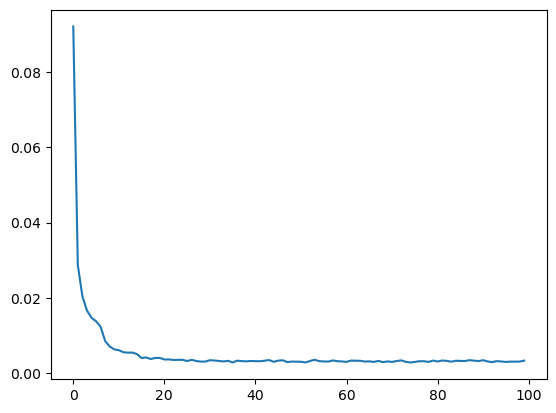

In [14]:
from IPython.display import Image

if train:
    # show loss curve from your training.
    plt.plot(training_result["losses"])
    plt.show()
else:
    # If you are loading a checkpoint instead of training the model (train = False),
    # the following line will show a pre-saved loss curve from the checkpoint data.
    display(Image(filename="images/loss-curve.png", height=600, width=600))

## Visualize the Vector Space!

### Generate 64d Representations of the Training Set

In [15]:
encoded_data = []
labels = []

with torch.no_grad():
    for anchor, _, _, label in tqdm(trainLoader):
        output = model(anchor.to(device))
        encoded_data.extend(output.cpu().numpy())
        labels.extend(label.cpu().numpy())

encoded_data = np.array(encoded_data)
labels = np.array(labels)

  0%|          | 0/2563 [00:00<?, ?it/s]

### Reduce Dimensionality of Data: 64d -> 3d

In [16]:
# Apply PCA to reduce dimensionality of data from 64d -> 3d to make it easier to visualize!
pca = PCA(n_components=3)
encoded_data_3d = pca.fit_transform(encoded_data)

### Interactive Scatter Plot in 3d – with PCA

In [17]:
scatter = go.Scatter3d(
    x=encoded_data_3d[:, 0],
    y=encoded_data_3d[:, 1],
    z=encoded_data_3d[:, 2],
    mode='markers',
    marker=dict(size=4, color=labels, colorscale='Viridis', opacity=0.8),
    text=labels, 
    hoverinfo='text',
)

# Create layout
layout = go.Layout(
    title="MNIST Dataset - Encoded and PCA Reduced 3D Scatter Plot",
    scene=dict(
        xaxis=dict(title="PC1"),
        yaxis=dict(title="PC2"),
        zaxis=dict(title="PC3"),
    ),
    width=1000, 
    height=750,
)

# Create figure and add scatter plot
fig = go.Figure(data=[scatter], layout=layout)

# Show the plot
fig.show()

### Scatterplot in 2d - with UMAP

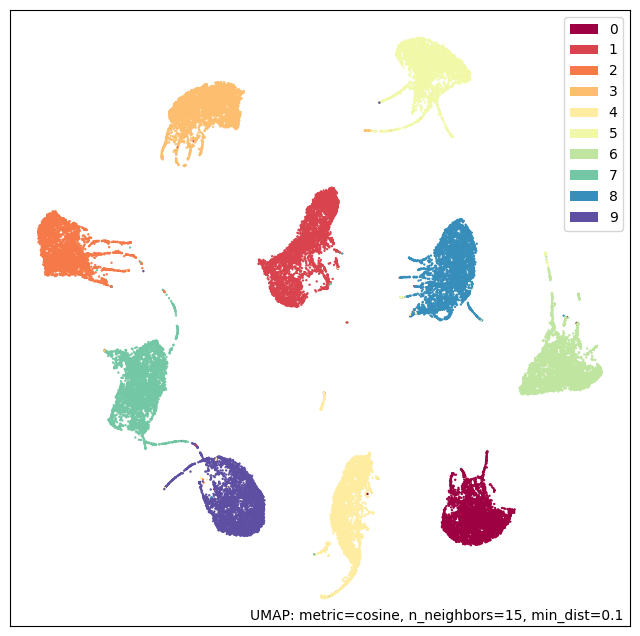

In [18]:
mapper = umap.UMAP(random_state=42, metric='cosine').fit(encoded_data)
umap.plot.points(mapper, labels=labels);

> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern. Also the previous cell might take some minutes to run.

### UMAP with Euclidian Metric

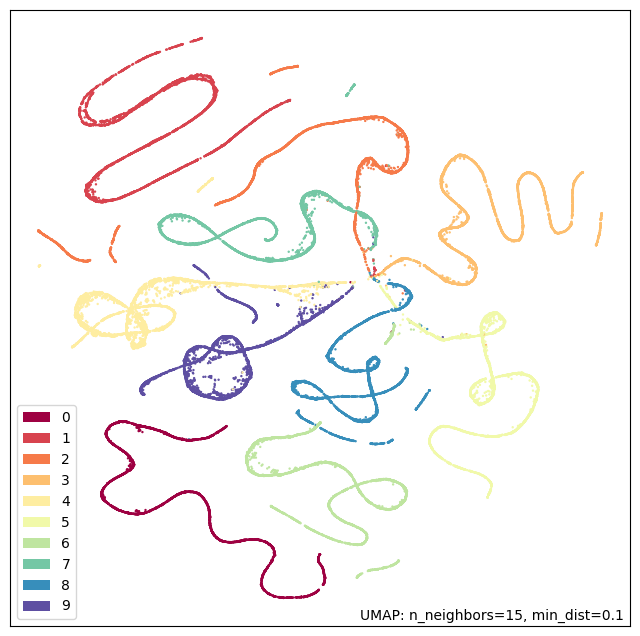

In [19]:
mapper = umap.UMAP(random_state=42).fit(encoded_data) 
umap.plot.points(mapper, labels=labels);

> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern. 

## Contrastive Training over 100 Epochs!

In [20]:
# Run it to see the training!
from IPython.display import Video
Video("contrastive_Training_100.mp4", height=500)

# L2: Multimodal Search

## Setup
### Load environment variables and API keys

In [21]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")

## Connect to Weaviate

In [22]:
import weaviate, os

client = weaviate.connect_to_embedded(
    version="1.24.21",
    environment_variables={
        "ENABLE_MODULES": "backup-filesystem,multi2vec-palm",
        "BACKUP_FILESYSTEM_PATH": "/home/jovyan/work/L2/backups",
    },
    headers={
        "X-PALM-Api-Key": EMBEDDING_API_KEY,
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 413


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2025-02-12T14:01:44Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2025-02-12T14:01:44Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2025-02-12T14:01:44Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2025-02-12T14:01:44Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"2025-02-12T14:01:44Z"}
/usr/local/lib/python3.11/site-packages/weaviate/warnings.py:130: DeprecationWarning:

Dep005: You are using weaviate-client version 4.5.4. The latest version is 4.10.4.
        

True

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:91893c82-6ea4-4086-a665-35575a726d3a Type:INIT Version:1.24.21 NumObjects:0 OS:linux Arch:amd64 UsedModules:[]}","time":"2025-02-12T14:01:45Z"}


## Create the Collection

In [23]:
from weaviate.classes.config import Configure

# Just checking if you ever need to re run it
if(client.collections.exists("Animals")):
    client.collections.delete("Animals")
    
client.collections.create(
    name="Animals",
    vectorizer_config=Configure.Vectorizer.multi2vec_palm(
        image_fields=["image"],
        video_fields=["video"],
        project_id="semi-random-dev",
        location="us-central1",
        model_id="multimodalembedding@001",
        dimensions=1408,        
    )
)

{"level":"warning","msg":"prop len tracker file /home/jovyan/.local/share/weaviate/animals/CNBQbQa2lgYI/proplengths does not exist, creating new tracker","time":"2025-02-12T14:01:48Z"}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2025-02-12T14:01:48Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Created shard animals_CNBQbQa2lgYI in 3.118658ms","time":"2025-02-12T14:01:48Z"}


{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-02-12T14:01:48Z","took":56796}


## Helper functions

In [24]:
import base64

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

## Insert Images into Weaviate


In [25]:
animals = client.collections.get("Animals")

source = os.listdir("./source/animal_image/")

with animals.batch.rate_limit(requests_per_minute=100) as batch:
    for name in source:
        print(f"Adding {name}")
        
        path = "./source/image/" + name
    
        batch.add_object({
            "name": name,            # name of the file
            "path": path,            # path to the file to display result
            "image": toBase64(path), # this gets vectorized - "image" was configured in vectorizer_config as the property holding images
            "mediaType": "image",    # a label telling us how to display the resource 
        })

Adding cat1.jpg
Adding dog3.jpg
Adding dog1.jpg
Adding cat3.jpg
Adding meerkat2.jpg
Adding cat2.jpg
Adding meerkat1.jpg
Adding dog2.jpg
Adding meerkat3.jpg


In [26]:
# Check for failed objects
if len(animals.batch.failed_objects) > 0:
    print(f"Failed to import {len(animals.batch.failed_objects)} objects")
    for failed in animals.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("No errors")

No errors


## Insert Video Files into Weaviate
> Note: the input video must be at least 4 seconds long.

In [27]:
animals = client.collections.get("Animals")

source = os.listdir("../L2/source/video/")

for name in source:
    print(f"Adding {name}")
    path = "./source/video/" + name    

    # insert videos one by one
    animals.data.insert({
        "name": name,
        "path": path,
        "video": toBase64(path),
        "mediaType": "video"
    })

Adding meerkat-watch.mp4
Adding cat-play.mp4
Adding meerkat-dig.mp4
Adding dog-high-five.mp4
Adding dog-with-stick.mp4
Adding cat-clean.mp4


In [28]:
# Check for failed objects
if len(animals.batch.failed_objects) > 0:
    print(f"Failed to import {len(animals.batch.failed_objects)} objects")
    for failed in animals.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("No errors")

No errors


## Check count
> Total count should be 15 (9x image + 6x video)

In [29]:
agg = animals.aggregate.over_all(
    group_by="mediaType"
)

for group in agg.groups:
    print(group)

AggregateGroup(grouped_by=GroupedBy(prop='mediaType', value='image'), properties={}, total_count=9)
AggregateGroup(grouped_by=GroupedBy(prop='mediaType', value='video'), properties={}, total_count=6)


## Build MultiModal Search
### Helper Functions

In [30]:
# Helper functions to display results
import json
from IPython.display import Image, Video

def json_print(data):
    print(json.dumps(data, indent=2))

def display_media(item):
    path = item["path"]

    if(item["mediaType"] == "image"):
        display(Image(path, width=300))

    elif(item["mediaType"] == "video"):
        display(Video(path, width=300))

In [31]:
import base64, requests

# Helper function – get base64 representation from an online image
def url_to_base64(url):
    image_response = requests.get(url)
    content = image_response.content
    return base64.b64encode(content).decode('utf-8')

# Helper function - get base64 representation from a local file
def file_to_base64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

## Text to Media Search

In [32]:
animals = client.collections.get("Animals")

response = animals.query.near_text(
    query="dog playing with stick",
    return_properties=['name','path','mediaType'],
    limit=3
)

{
  "mediaType": "video",
  "path": "./source/video/dog-with-stick.mp4",
  "name": "dog-with-stick.mp4"
}


{
  "mediaType": "image",
  "path": "./source/image/dog3.jpg",
  "name": "dog3.jpg"
}


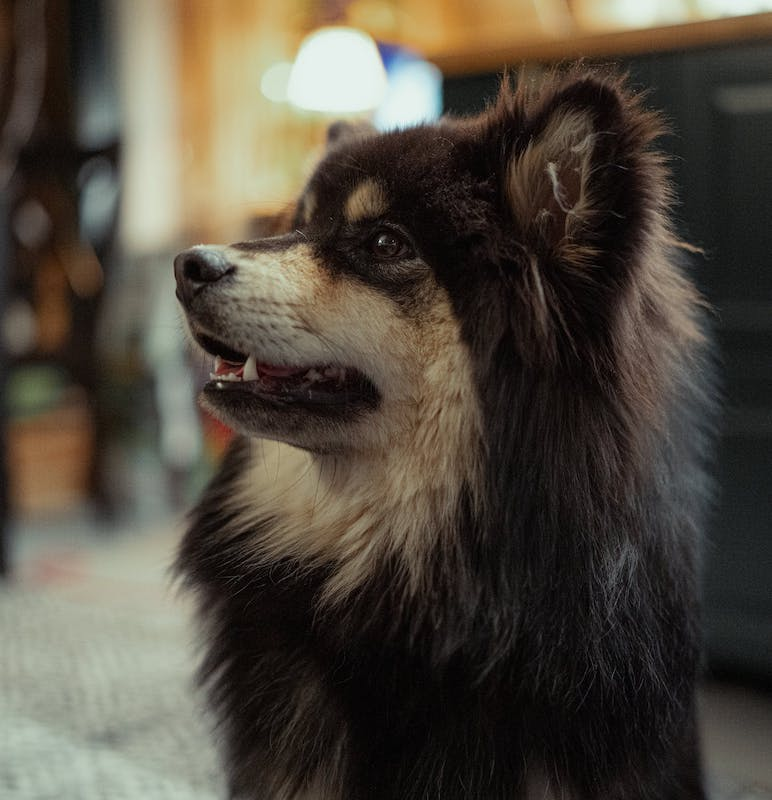

{
  "mediaType": "video",
  "path": "./source/video/dog-high-five.mp4",
  "name": "dog-high-five.mp4"
}


In [33]:
for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

## Image to Media Search

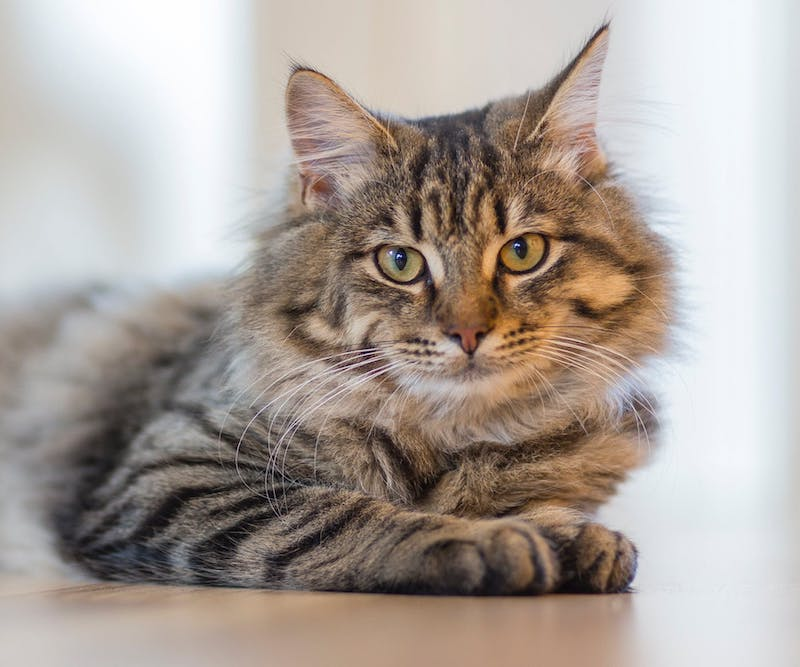

In [34]:
# Use this image as an input for the query
Image("../L2/test/test-cat.jpg", width=300)

{
  "mediaType": "image",
  "path": "./source/image/cat2.jpg",
  "name": "cat2.jpg"
}


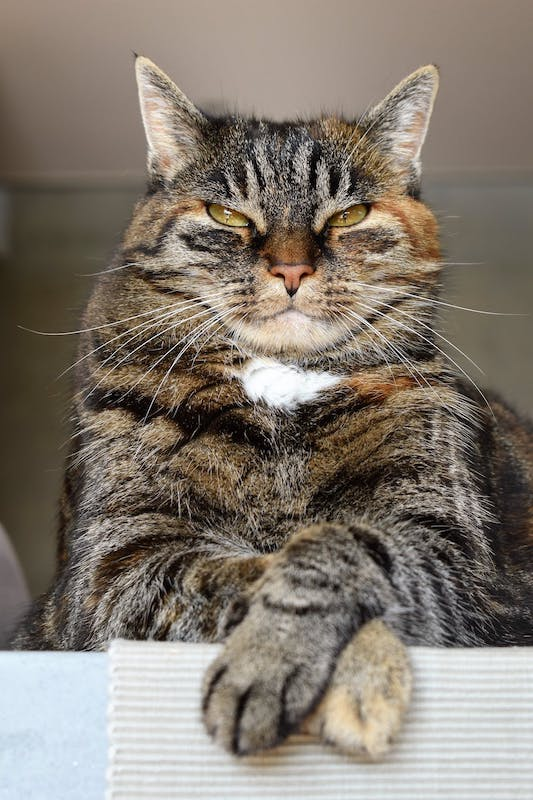

{
  "mediaType": "image",
  "path": "./source/image/cat1.jpg",
  "name": "cat1.jpg"
}


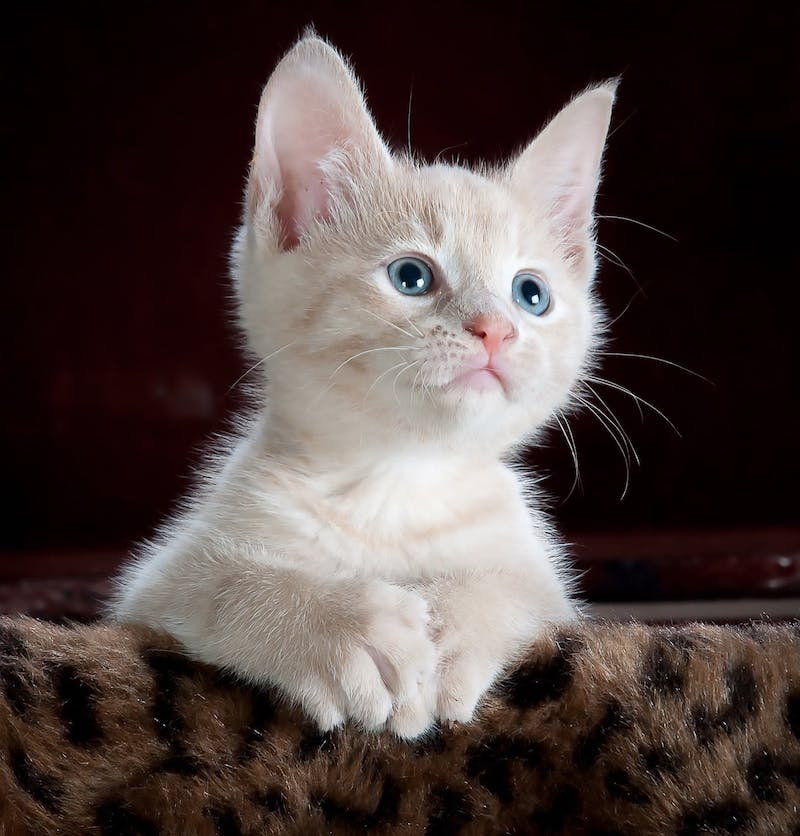

{
  "mediaType": "image",
  "path": "./source/image/cat3.jpg",
  "name": "cat3.jpg"
}


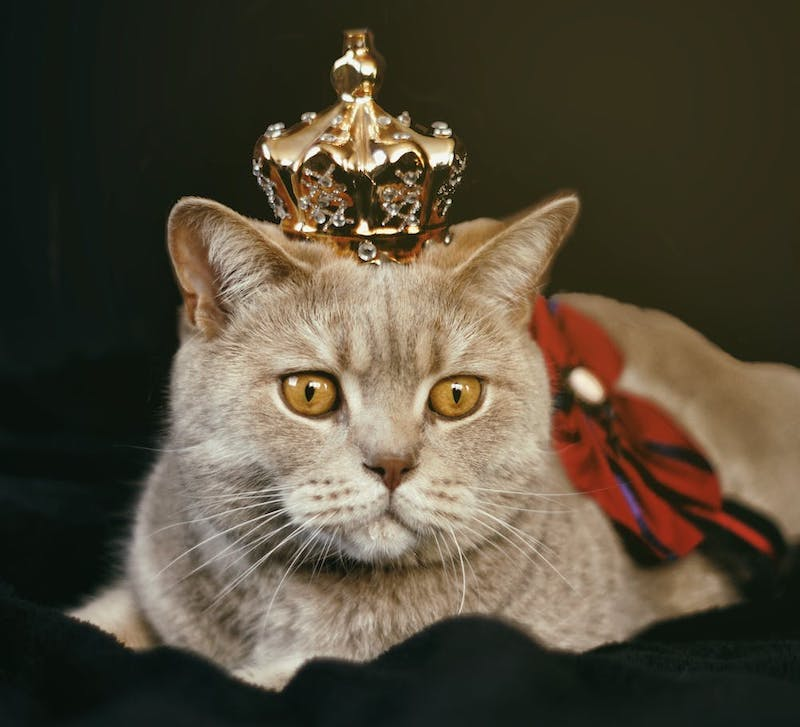

In [35]:
# The query
response = animals.query.near_image(
    near_image=file_to_base64("../L2/test/test-cat.jpg"),
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

## Image search - from web URL

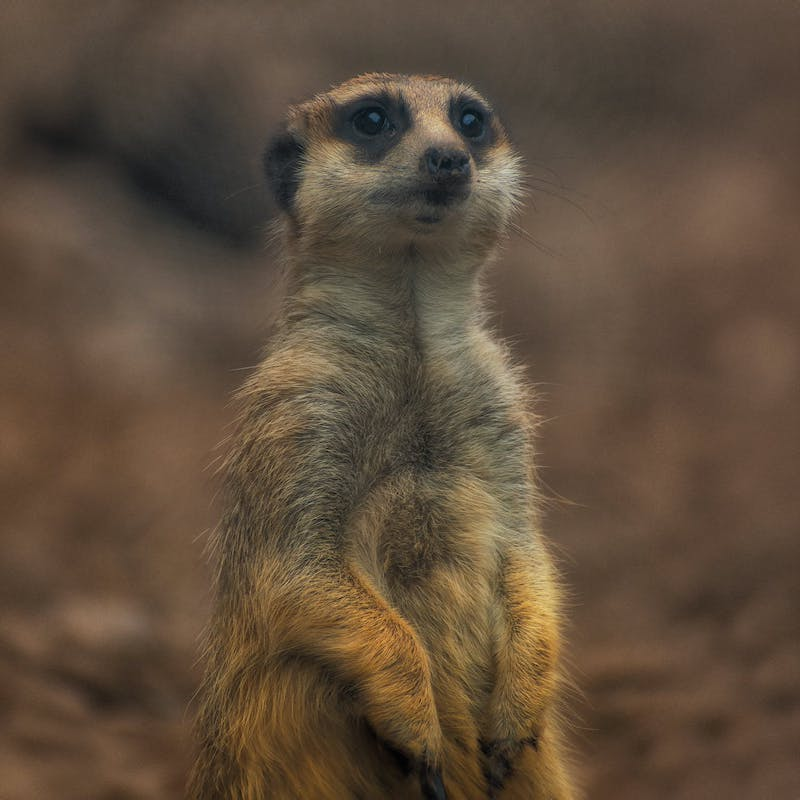

In [36]:
Image("https://raw.githubusercontent.com/weaviate-tutorials/multimodal-workshop/main/2-multimodal/test/test-meerkat.jpg", width=300)

{
  "mediaType": "image",
  "path": "./source/image/meerkat1.jpg",
  "name": "meerkat1.jpg"
}


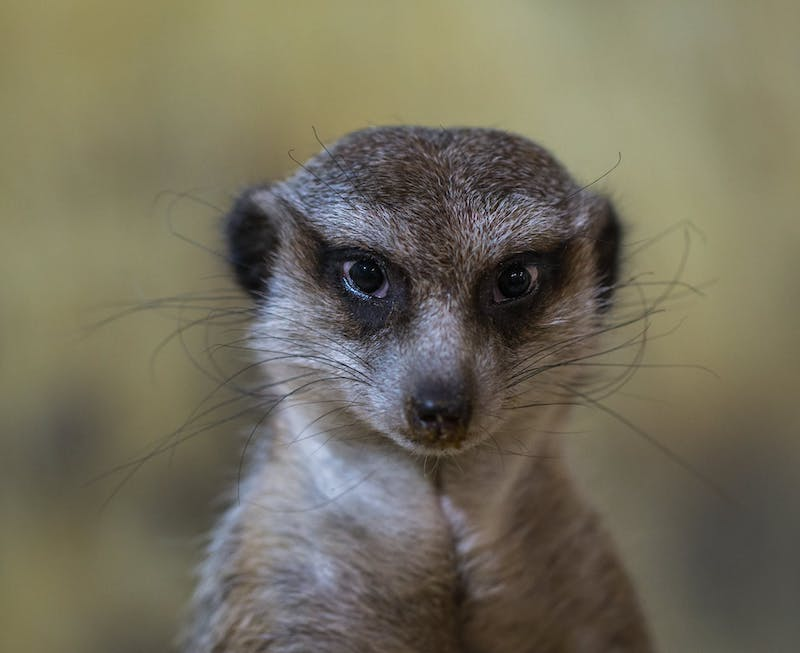

{
  "mediaType": "image",
  "path": "./source/image/meerkat3.jpg",
  "name": "meerkat3.jpg"
}


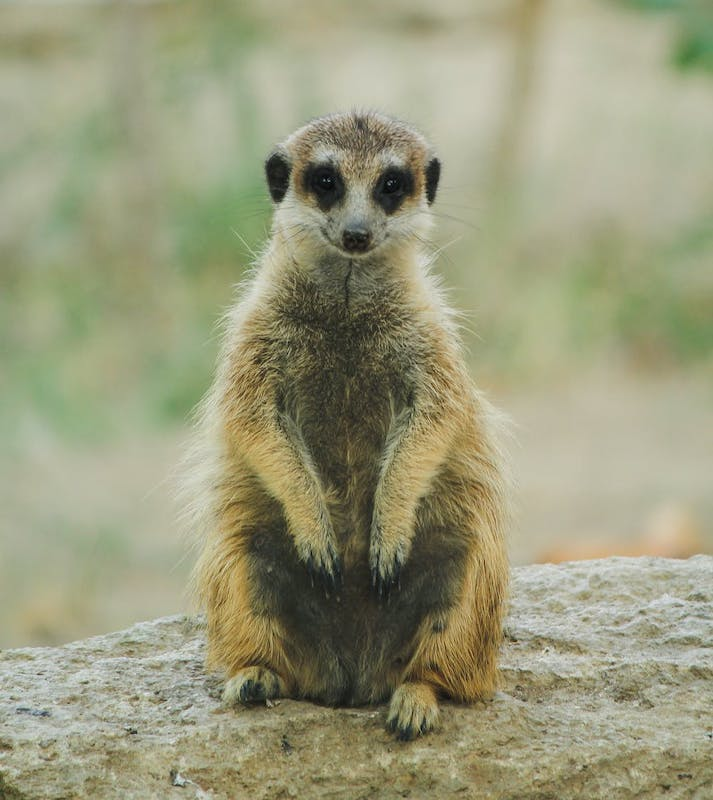

{
  "mediaType": "video",
  "path": "./source/video/meerkat-watch.mp4",
  "name": "meerkat-watch.mp4"
}


In [37]:
# The query
response = animals.query.near_image(
    near_image=url_to_base64("https://raw.githubusercontent.com/weaviate-tutorials/multimodal-workshop/main/2-multimodal/test/test-meerkat.jpg"),
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    json_print(obj.properties)
    display_media(obj.properties)

## Video to Media Search
> Note: the input video must be at least 4 seconds long.

In [39]:
Video("../L2/test/test-meerkat.mp4", width=400)

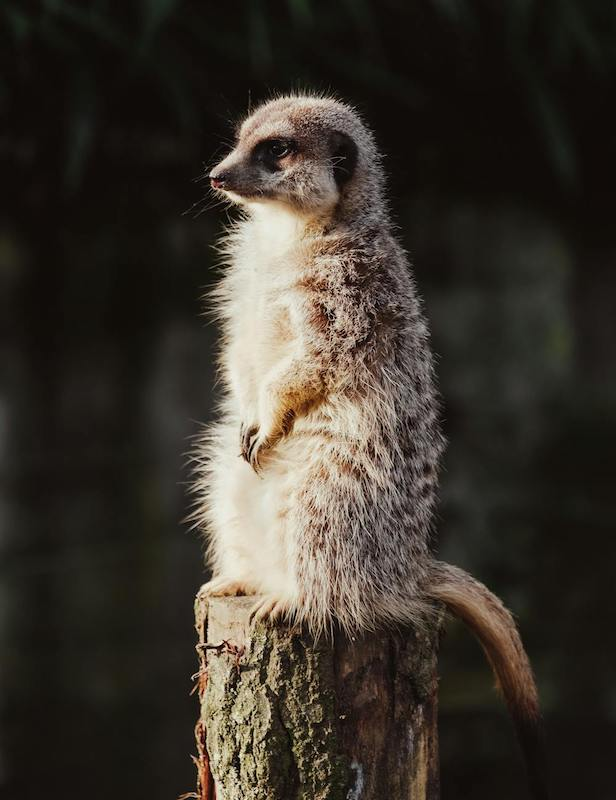

In [41]:
from weaviate.classes.query import NearMediaType

response = animals.query.near_media(
    media=file_to_base64("../L2/test/test-meerkat.mp4"),
    media_type=NearMediaType.VIDEO,
    return_properties=['name','path','mediaType'],
    limit=3
)

for obj in response.objects:
    # json_print(obj.properties)
    display_media(obj.properties)

## Visualizing a Multimodal Vector Space

> To make this more exciting, let's loadup a large dataset!

In [42]:
import numpy as np
import sklearn.datasets
import pandas as pd
import umap
import umap.plot
import matplotlib.pyplot as plt

## Load vector embeddings and mediaType from Weaviate 

In [44]:
client.backup.restore(
    backup_id="resources-img-and-vid",
    include_collections="Resources",
    backend="filesystem"
)

# It can take a few seconds for the "Resources" collection to be ready.
# We add 5 seconds of sleep to make sure it is ready for the next cells to use.
import time
time.sleep(5)

{"action":"try_restore","backend":"filesystem","backup_id":"resources-img-and-vid","level":"info","msg":"","time":"2025-02-12T14:15:15Z","took":3343051}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2025-02-12T14:15:16Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 6.796801ms","time":"2025-02-12T14:15:16Z"}
{"action":"restore","backup_id":"resources-img-and-vid","class":"Resources","level":"info","msg":"successfully restored","time":"2025-02-12T14:15:16Z"}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"backup restored successfully","time":"2025-02-12T14:15:16Z"}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-02-12T14:15:16Z","took":180932053}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","

In [45]:
# Collection named "Resources"
collection = client.collections.get("Resources")

embs = []
labs = []
for item in collection.iterator(include_vector=True):
    #print(item.properties)\
    labs.append(item.properties['mediaType'])
    embs.append(item.vector)

In [46]:
embs2 = [emb['default'] for emb in embs]

emb_df = pd.DataFrame(embs2)
labels = pd.Series(labs)

labels[labels=='image'] = 0
labels[labels=='video'] = 1

>Note: this might take some minutes to complete the execution.

In [47]:
%%time
mapper2 = umap.UMAP().fit(emb_df)

CPU times: user 47.7 s, sys: 666 ms, total: 48.4 s
Wall time: 7.91 s


## Plot the embeddings

<Figure size 1000x800 with 0 Axes>

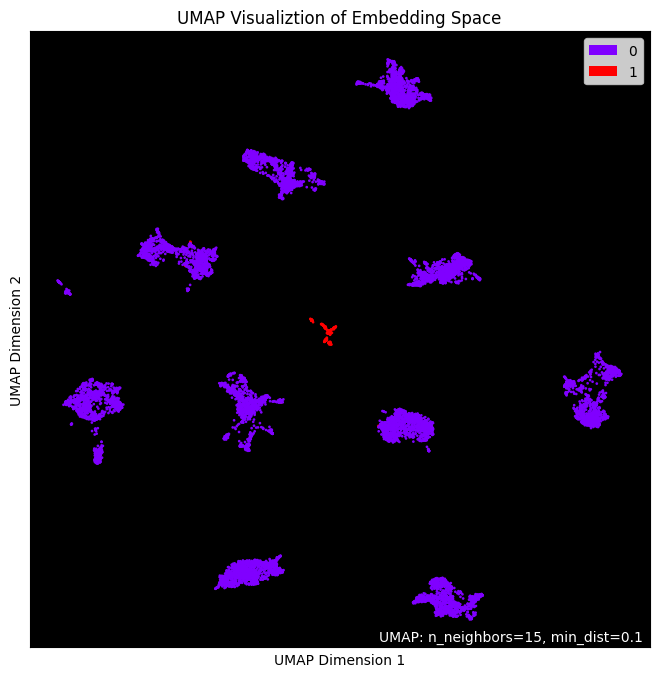

In [48]:
plt.figure(figsize=(10, 8))
umap.plot.points(mapper2, labels=labels, theme='fire')

# Show plot
plt.title('UMAP Visualiztion of Embedding Space')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show();

## Interactive plot of vectors

In [49]:
umap.plot.output_notebook()

p = umap.plot.interactive(mapper2, labels=labels, theme='fire')

umap.plot.show(p)

Loading BokehJS ...

/usr/local/lib/python3.11/site-packages/umap/plot.py:1471: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.



## Close the connection to Weaviate

In [50]:
client.close()

{"action":"restapi_management","level":"info","msg":"Shutting down... ","time":"2025-02-12T14:18:57Z"}
{"action":"restapi_management","level":"info","msg":"Stopped serving weaviate at http://127.0.0.1:8079","time":"2025-02-12T14:18:57Z"}
{"action":"telemetry_push","level":"info","msg":"telemetry terminated","payload":"\u0026{MachineID:91893c82-6ea4-4086-a665-35575a726d3a Type:TERMINATE Version:1.24.21 NumObjects:13609 OS:linux Arch:amd64 UsedModules:[multi2vec-google-vertex-ai]}","time":"2025-02-12T14:18:58Z"}


# L3: Large Multimodal Models (LMMs)

## Setup
### Load environment variables and API keys

In [51]:
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv()) # read local .env file
GOOGLE_API_KEY=os.getenv('GOOGLE_API_KEY')

In [52]:
# Set the genai library
import google.generativeai as genai
from google.api_core.client_options import ClientOptions

genai.configure(
        api_key=GOOGLE_API_KEY,
        transport="rest",
        client_options=ClientOptions(
            api_endpoint=os.getenv("GOOGLE_API_BASE"),
        ),
)

## Helper functions

In [53]:
import textwrap
import PIL.Image
from IPython.display import Markdown, Image

def to_markdown(text):
    text = text.replace('•', '  *')
    return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


* Function to call LMM (Large Multimodal Model).

In [54]:
def call_LMM(image_path: str, prompt: str) -> str:
    # Load the image
    img = PIL.Image.open(image_path)

    # Call generative model
    model = genai.GenerativeModel('gemini-1.5-flash')
    response = model.generate_content([prompt, img], stream=False)
    response.resolve()

    return to_markdown(response.text)  

## Analyze images with an LMM

In [55]:
# Pass in an image and see if the LMM can answer questions about it
Image(url= "../L3/SP-500-Index-Historical-Chart.jpg")

In [56]:
# Use the LMM function
call_LMM("../L3/SP-500-Index-Historical-Chart.jpg", 
    "Explain what you see in this image.")

> The image shows a line graph titled "S&P 500 Index Historical Chart".  The graph plots the value of the S&P 500 index over time, from approximately 1960 to 2020. The x-axis represents the year, and the y-axis represents the index value.  The line shows a general upward trend, indicating overall growth in the index over the period shown, with some fluctuations and dips along the way.  The graph illustrates the long-term growth of the S&P 500.


## Analyze a harder image

In [57]:
Image(url= "../L3/clip.png")

In [58]:
call_LMM("../L3/clip.png", 
    "Explain what this figure is and where is this used.")

> This figure depicts the process of **Contrastive Pre-training** for a multimodal model (likely for image-text retrieval).  Let's break down the components:
> 
> 1. **Data Input:** The process starts with paired image and text data.  For example, an image of a dog with the caption "Pepper the aussie pup".  Multiple image-text pairs are used.
> 
> 2. **Encoders:**
>     * **Image Encoder:**  This neural network takes an image as input and transforms it into a vector representation (a numerical embedding) capturing its essential features.  This is represented by I₁, I₂, I₃... Iₙ where each I represents the embedding of a different image.
>     * **Text Encoder:** This network does the same but for text captions.  It encodes each text caption into a vector representation (T₁, T₂, T₃... Tₙ where each T is a text embedding).
> 
> 3. **Contrastive Loss:**  The core of contrastive pre-training is the contrastive loss function. The encoders generate image and text embeddings.  The resulting matrix shows all possible pairings between image and text embeddings. The model is trained to:
>     * **Maximize similarity:**  For correct image-text pairs (e.g., I₁ and T₁), the embeddings should be very similar (close in vector space).  The model is rewarded when it produces similar embeddings for correct matches.  This is shown by highlighting the diagonal (I₁T₁, I₂T₂, etc.) in the matrix.
>     * **Minimize similarity:**  For incorrect image-text pairs (e.g., I₁ and T₂), the embeddings should be dissimilar (far apart in vector space).  The model is penalized when it produces similar embeddings for mismatches, which is indirectly shown by the non-highlighted cells.
> 
> 4. **Use Case:** This pre-training method is used to learn good image and text representations before the model is fine-tuned for downstream tasks.  Downstream tasks might include:
>     * **Image-text retrieval:** Given an image, find the most relevant text description, or vice versa.
>     * **Image captioning:** Generate a caption for a given image.
>     * **Visual question answering (VQA):** Answer questions about an image.
> 
> In essence, the contrastive pre-training step teaches the model to understand the relationship between images and their textual descriptions by forcing it to learn meaningful representations that capture the semantic similarity between them. This pre-trained model then serves as a strong foundation for various tasks involving both image and text modalities.


## Decode the hidden message

In [59]:
Image(url= "../L3/blankimage3.png")

In [60]:
# Ask to find the hidden message
call_LMM("../L3/blankimage3.png", 
    "Read what you see on this image.")

> Here's what the image says:
> 
> You can vectorize
> the whole world
> with Weaviate!

## How the model sees the picture!

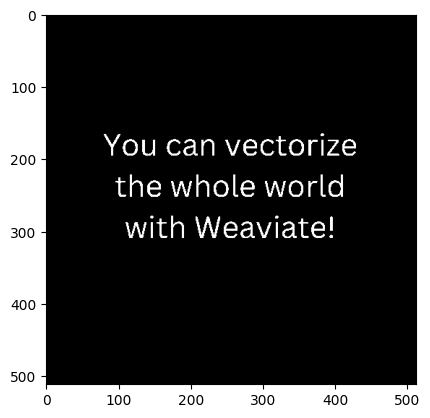

In [62]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

image = imageio.imread("../L3/blankimage3.png")

# Convert the image to a NumPy array
image_array = np.array(image)

plt.imshow(np.where(image_array[:,:,0]>120, 0,1), cmap='gray');

In [63]:
# Create a hidden text in an image
def create_image_with_text(text, font_size=20, font_family='sans-serif', text_color='#73D955', background_color='#7ED957'):
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.patch.set_facecolor(background_color)
    ax.text(0.5, 0.5, text, fontsize=font_size, ha='center', va='center', color=text_color, fontfamily=font_family)
    ax.axis('off')
    plt.tight_layout()
    return fig

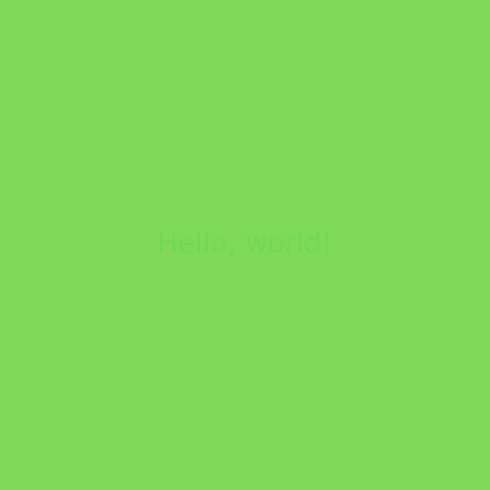

In [64]:
# Modify the text here to create a new hidden message image!
fig = create_image_with_text("Hello, world!") 

# Plot the image with the hidden message
plt.show()
fig.savefig("extra_output_image.png")

In [65]:
# Call the LMM function with the image just generated
call_LMM("extra_output_image.png", 
    "Read what you see on this image.")

> The image contains a solid light green background.  In the center, in a lighter shade of off-white, the text "Hello, world!" is displayed.


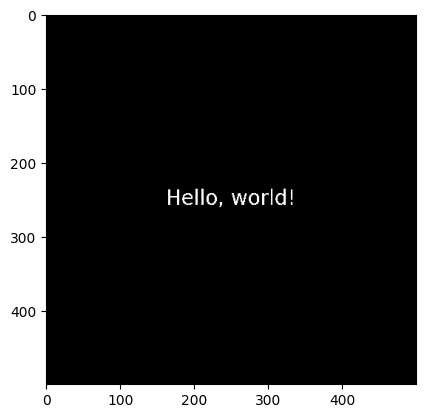

In [66]:
image = imageio.imread("extra_output_image.png")

# Convert the image to a NumPy array
image_array = np.array(image)

plt.imshow(np.where(image_array[:,:,0]>120, 0,1), cmap='gray');

# L4: Multimodal Retrieval Augmented Generation (MM-RAG)

## Setup
### Load environment variables and API keys#

In [67]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")

### Connect to Weaviate

In [68]:
import weaviate

client = weaviate.connect_to_embedded(
    version="1.24.21",
    environment_variables={
        "ENABLE_MODULES": "backup-filesystem,multi2vec-palm",
        "BACKUP_FILESYSTEM_PATH": "/home/jovyan/work/L4/backups",
    },
    headers={
        "X-PALM-Api-Key": EMBEDDING_API_KEY,
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 1713


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2025-02-12T14:29:53Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2025-02-12T14:29:53Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2025-02-12T14:29:53Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2025-02-12T14:29:53Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"2025-02-12T14:29:53Z"}
/usr/local/lib/python3.11/site-packages/weaviate/warnings.py:130: DeprecationWarning:

Dep005: You are using weaviate-client version 4.5.4. The latest version is 4.10.4.
        

True

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:c271fa3d-79c6-4759-a780-1cc1de27d6ab Type:INIT Version:1.24.21 NumObjects:0 OS:linux Arch:amd64 UsedModules:[multi2vec-google-vertex-ai]}","time":"2025-02-12T14:29:54Z"}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2025-02-12T14:29:54Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Completed loading shard animals_CNBQbQa2lgYI in 2.750592ms","time":"2025-02-12T14:29:54Z"}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2025-02-12T14:29:54Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 5.426776ms","time":"2025-02-12T14:29:54Z"}
{"action":"hnsw_vector_cache_prefill","count":3000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","ti

### Restore 13k+ prevectorized resources

In [69]:
client.collections.delete("Resources")

client.backup.restore(
    backup_id="resources-img-and-vid",
    include_collections="Resources",
    backend="filesystem"
)

# It can take a few seconds for the "Resources" collection to be ready.
# We add 5 seconds of sleep to make sure it is ready for the next cells to use.
import time
time.sleep(5)

{"action":"try_restore","backend":"filesystem","backup_id":"resources-img-and-vid","level":"info","msg":"","time":"2025-02-12T14:30:31Z","took":2525677}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2025-02-12T14:30:42Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 4.4515ms","time":"2025-02-12T14:30:42Z"}
{"action":"restore","backup_id":"resources-img-and-vid","class":"Resources","level":"info","msg":"successfully restored","time":"2025-02-12T14:30:42Z"}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"backup restored successfully","time":"2025-02-12T14:30:42Z"}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-02-12T14:30:42Z","took":117957641}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","ms

### Preview data count

In [70]:
from weaviate.classes.aggregate import GroupByAggregate

resources = client.collections.get("Resources")

response = resources.aggregate.over_all(
    group_by=GroupByAggregate(prop="mediaType")
)

# print rounds names and the count for each
for group in response.groups:
    print(f"{group.grouped_by.value} count: {group.total_count}")

image count: 13394
video count: 200


## Multimodal RAG

### Step 1 – Retrieve content from the database with a query

In [71]:
from IPython.display import Image
from weaviate.classes.query import Filter

def retrieve_image(query):
    resources = client.collections.get("Resources")
# ============
    response = resources.query.near_text(
        query=query,
        filters=Filter.by_property("mediaType").equal("image"), # only return image objects
        return_properties=["path"],
        limit = 1,
    )
# ============
    result = response.objects[0].properties
    return result["path"] # Get the image path

### Run image retrieval

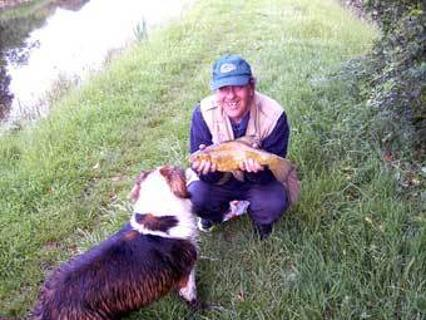

In [72]:
# Try with different queries to retreive an image
img_path = retrieve_image("fishing with my buddies")
display(Image(img_path))

### Step 2 - Generate a description of the image

In [73]:
import google.generativeai as genai
from google.api_core.client_options import ClientOptions

# Set the Vision model key
genai.configure(
        api_key=GOOGLE_API_KEY,
        transport="rest",
        client_options=ClientOptions(
            api_endpoint=os.getenv("GOOGLE_API_BASE"),
        ),
)

In [74]:
# Helper function
import textwrap
import PIL.Image
from IPython.display import Markdown, Image

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

def call_LMM(image_path: str, prompt: str) -> str:
    img = PIL.Image.open(image_path)

    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content([prompt, img], stream=False)
    response.resolve()

    return to_markdown(response.text)    

### Run vision request

In [75]:
call_LMM(img_path, "Please describe this image in detail.")

> Here's a description of the image:
> 
> Eye-level view of a man holding a fish, with a dog sitting beside him. 
> 
> 
> Here's a breakdown of the scene:
> 
> * **The Man:** A man with fair skin is crouched down. He's wearing a green baseball cap, a light beige or tan long-sleeved shirt, and appears to be wearing darker pants. He has a friendly expression and is holding a medium-sized, golden-colored fish.
> 
> * **The Fish:** The fish appears to be a tench or a similar type of freshwater fish, displaying a fairly smooth, golden-brown color. The man holds it carefully.
> 
> * **The Dog:** A medium-sized, tri-color dog (black, brown, and white) is sitting to the man's left. It seems to be a type of herding dog, possibly a Border Collie mix or similar breed. Its fur looks a bit wet or damp.
> 
> * **The Setting:** The scene is outdoors, on a grassy bank next to a body of water. The grass is lush and green. A portion of calm water is visible in the background, suggesting a lake or pond. There's some sparse, slightly overgrown vegetation further back. The overall lighting suggests it's daytime.
> 
> The overall impression is a pleasant, casual scene of a man enjoying a successful fishing trip with his dog. The image has a somewhat rustic or natural feel.


## All together

In [76]:
def mm_rag(query):
    # Step 1 - retrieve an image – Weaviate
    SOURCE_IMAGE = retrieve_image(query)
    display(Image(SOURCE_IMAGE))
#===========

    # Step 2 - generate a description - GPT4
    description = call_LMM(SOURCE_IMAGE, "Please describe this image in detail.")
    return description

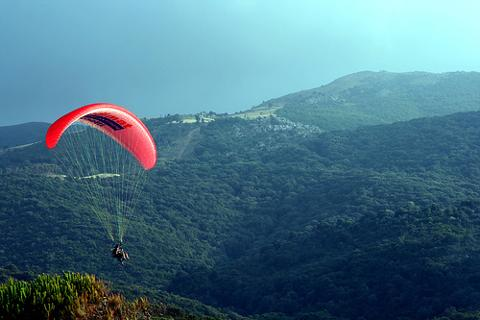

> Here's a description of the image:
> 
> Eye-level view of a red paraglider soaring over a vast, mountainous landscape. 
> 
> 
> Here's a breakdown of the scene:
> 
> * **Foreground:** The immediate foreground shows a slightly blurred section of low-lying vegetation, possibly shrubs or small trees, at the bottom of a hillside.
> 
> * **Midground:** Dominating the midground is the vibrant red paraglider, appearing relatively small against the expansive backdrop. Two people are faintly visible within the paraglider's harness. The lines extending from the parachute are clearly visible.
> 
> * **Background:** The background stretches out into a panoramic view of rolling, densely forested hills and mountains that recede into the distance. The mountains are a muted bluish-green, suggesting distance and possibly atmospheric haze. The sky is a pale, almost washed-out blue, suggesting an overcast or hazy day.  In the far distance, near the horizon, there's a slightly lighter area on the mountain tops, possibly indicating a clearing or different type of vegetation.
> 
> 
> The overall impression is one of serenity, freedom, and vastness. The contrast between the bright red of the paraglider and the muted greens and blues of the landscape makes the paraglider stand out prominently. The image has a somewhat tranquil and peaceful atmosphere.


In [77]:
# Call mm_rag function
mm_rag("paragliding through the mountains")

In [78]:
# Remember to close the weaviate instance
client.close()

{"action":"restapi_management","level":"info","msg":"Shutting down... ","time":"2025-02-12T14:37:00Z"}
{"action":"restapi_management","level":"info","msg":"Stopped serving weaviate at http://127.0.0.1:8079","time":"2025-02-12T14:37:00Z"}
{"action":"telemetry_push","level":"info","msg":"telemetry terminated","payload":"\u0026{MachineID:c271fa3d-79c6-4759-a780-1cc1de27d6ab Type:TERMINATE Version:1.24.21 NumObjects:13609 OS:linux Arch:amd64 UsedModules:[multi2vec-google-vertex-ai]}","time":"2025-02-12T14:37:01Z"}


# L5: Industry Applications

In [79]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")

import google.generativeai as genai
from google.api_core.client_options import ClientOptions
genai.configure(
    api_key=GOOGLE_API_KEY,
    transport="rest",
    client_options=ClientOptions(
        api_endpoint=os.getenv("GOOGLE_API_BASE"),
    )
)

## Vision Function

In [80]:
import textwrap
import PIL.Image
from IPython.display import Markdown, Image

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

def call_LMM(image_path: str, prompt: str, plain_text: bool=False) -> str:
    img = PIL.Image.open(image_path)

    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content([prompt, img], stream=False)
    response.resolve()
    
    if(plain_text):
        return response.text
    else:
        return to_markdown(response.text)

## Extracting Structured Data from Retreived Images
### Analyzing an invoice

In [82]:
from IPython.display import Image

Image(url="../L5/invoice.png")

In [83]:
call_LMM("../L5/invoice.png",
    """Identify items on the invoice, Make sure you output 
    JSON with quantity, description, unit price and ammount.""")

> ```json
> [
>   {
>     "quantity": 1,
>     "description": "Front and rear brake cables",
>     "unit_price": 100.00,
>     "amount": 100.00
>   },
>   {
>     "quantity": 2,
>     "description": "New set of pedal arms",
>     "unit_price": 15.00,
>     "amount": 30.00
>   },
>   {
>     "quantity": 3,
>     "description": "Labor 3hrs",
>     "unit_price": 5.00,
>     "amount": 15.00
>   }
> ]
> ```

In [84]:
# Ask something else
call_LMM("../L5/invoice.png",
    """How much would four sets pedal arms cost
    and 6 hours of labour?""",
    plain_text=True
)

"Here's the breakdown of the cost:\n\n* **Pedal Arms:** One set of pedal arms costs $15.00.  Four sets would cost 4 * $15.00 = $60.00\n* **Labor:** The invoice shows that 3 hours of labor cost $15.00. Therefore, 1 hour of labor costs $5.00 ($15.00 / 3 hours = $5.00/hour). Six hours of labor would cost 6 * $5.00 = $30.00\n\n**Total Cost:** The combined cost of four sets of pedal arms and six hours of labor would be $60.00 + $30.00 = $90.00\n"

### Extracting Tables from Images

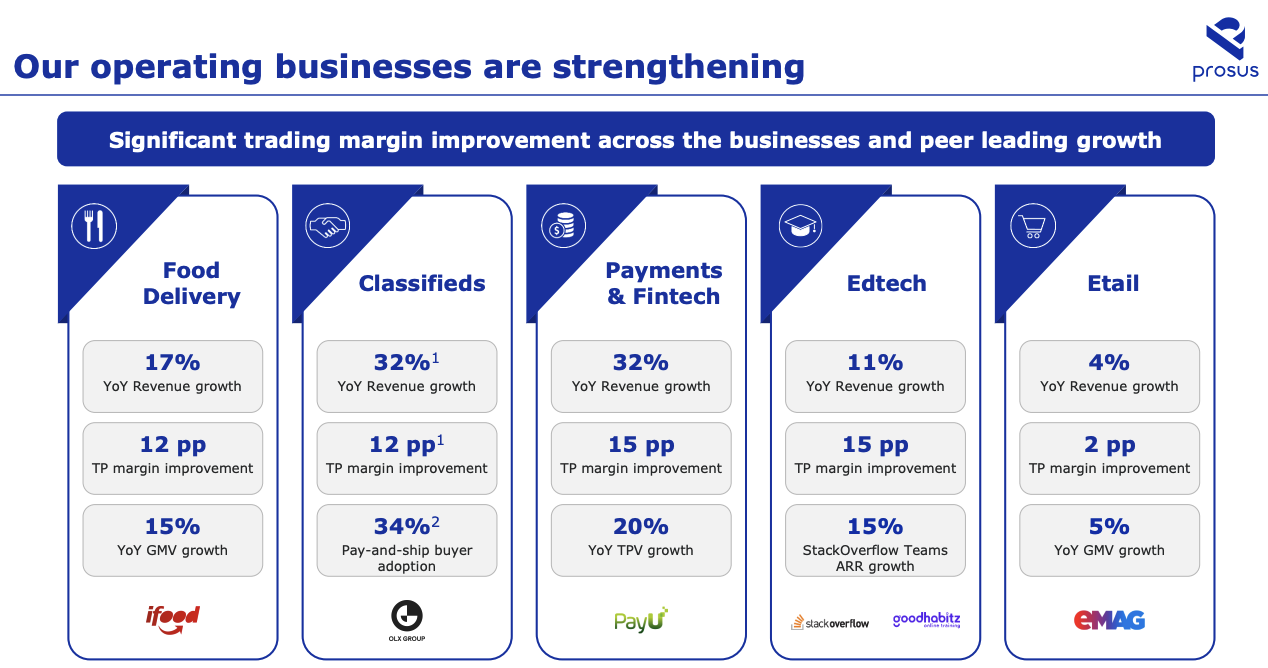

In [85]:
Image("../L5/prosus_table.png")

In [86]:
call_LMM("../L5/prosus_table.png", 
    "Print the contents of the image as a markdown table.")

> | Business          | YoY Revenue Growth | TP Margin Improvement | Other Key Metric                     | Other Key Metric Value |
> |-----------------|--------------------|-----------------------|--------------------------------------|-----------------------|
> | Food Delivery     | 17%                 | 12 pp                  | YoY GMV growth                         | 15%                    |
> | Classifieds       | 32%                 | 12 pp                  | Pay-and-ship buyer adoption           | 34%                    |
> | Payments & Fintech | 32%                 | 15 pp                  | YoY TPV growth                         | 20%                    |
> | Edtech            | 11%                 | 15 pp                  | StackOverflow Teams ARR growth         | 15%                    |
> | Etail             | 4%                  | 2 pp                   | YoY GMV growth                         | 5%                     |

In [87]:
call_LMM("../L5/prosus_table.png", 
    """Analyse the contents of the image as a markdown table.
    Which of the business units has the highest revenue growth?""")

> Here's a markdown table analyzing the provided image, followed by the answer to your question:
> 
> | Business Unit      | YoY Revenue Growth | TP Margin Improvement | Other Key Metric         | Other Metric Value | Company Examples      |
> |----------------------|---------------------|-----------------------|--------------------------|--------------------|-----------------------|
> | Food Delivery       | 17%                 | 12 pp                  | YoY GMV growth           | 15%                 | ifood                 |
> | Classifieds         | 32%                 | 12 pp                  | Pay-and-ship buyer adoption | 34%                 | OLX Group             |
> | Payments & Fintech | 32%                 | 15 pp                  | YoY TPV growth           | 20%                 | PayU                  |
> | Edtech              | 11%                 | 15 pp                  | StackOverflow Teams ARR growth | 15%                 | Stack Overflow, GoodHabitz |
> | Etail               | 4%                  | 2 pp                   | YoY GMV growth           | 5%                  | eMAG                  |
> 
> 
> **Which of the business units has the highest revenue growth?**
> 
> Both **Classifieds** and **Payments & Fintech** have the highest YoY revenue growth, at 32%.

### Analyzing Flow Charts

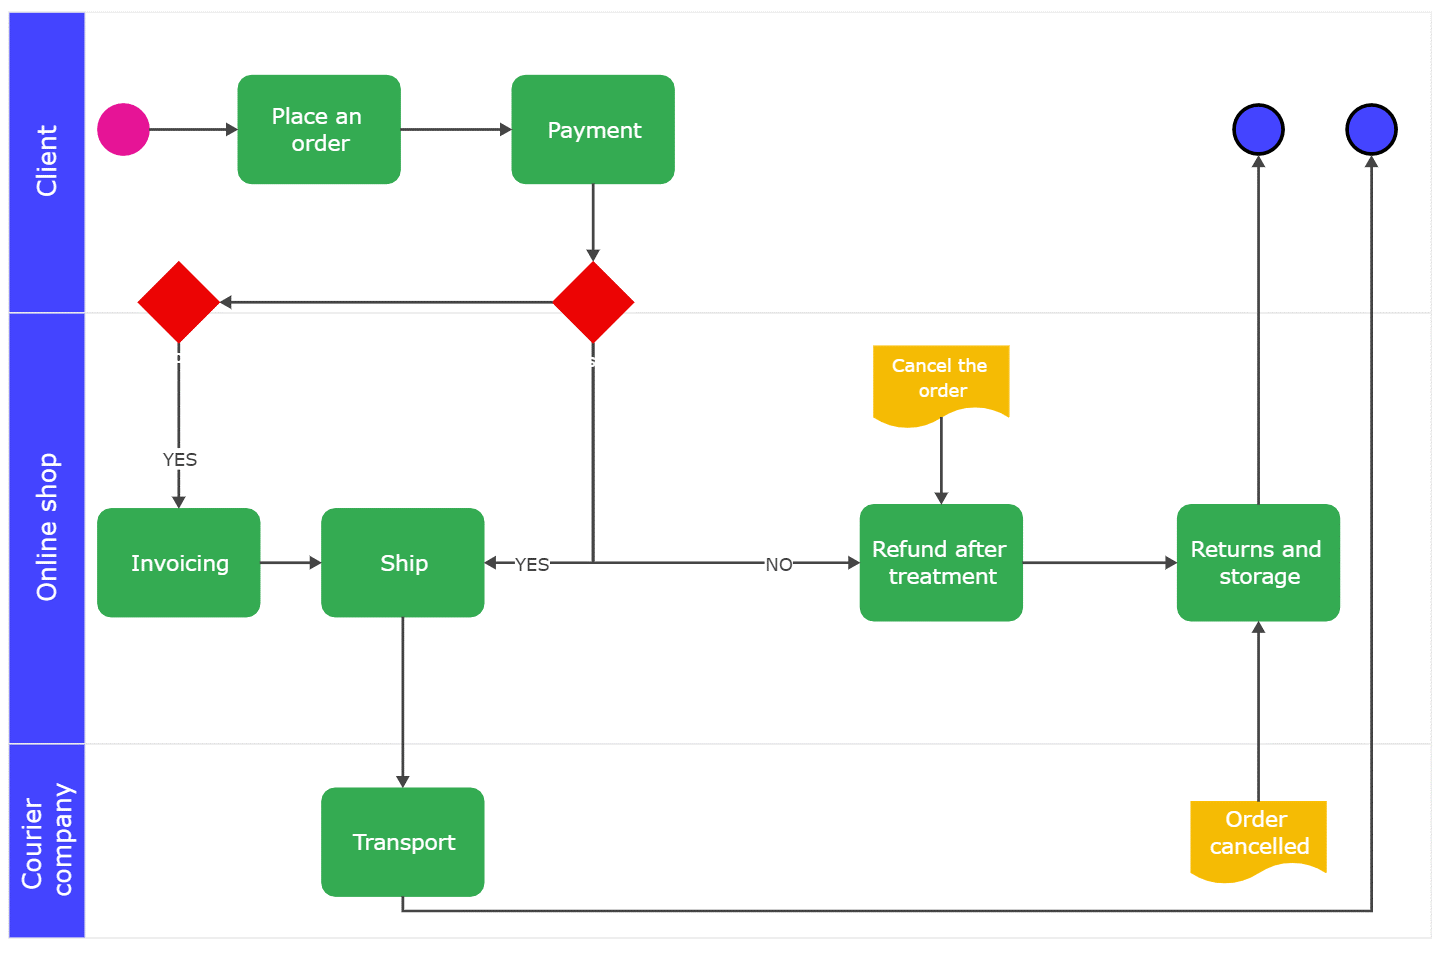

In [88]:
Image("../L5/swimlane-diagram-01.png")

In [89]:
call_LMM("../L5/swimlane-diagram-01.png", 
    """Provide a summarized breakdown of the flow chart in the image
    in a format of a numbered list.""")

> Here's a numbered list summarizing the flowchart:
> 
> 1. **Client places an order:** The process begins with a client placing an order.
> 
> 2. **Payment:** The client makes a payment for the order.
> 
> 3. **Order processing:**  A decision point determines if the order proceeds or is cancelled.
> 
> 4. **Order proceeds (YES):** If the order proceeds, invoicing is generated.
> 
> 5. **Shipping:** The order is shipped.
> 
> 6. **Transport:** The courier company transports the order.
> 
> 7. **Order cancellation (NO):** If the order is cancelled, a refund is processed after any necessary treatment.
> 
> 8. **Returns and storage:** After the refund, the returned items go to returns and storage.
> 
> 9. **Order cancelled notification:** The client receives notification that their order has been cancelled.

In [90]:
call_LMM("../L5/swimlane-diagram-01.png", 
    """Analyse the flow chart in the image,
    then output Python code
    that implements this logical flow in one function""")

> Here's a Python function that implements the logic shown in the flowchart:
> 
> ```python
> def order_processing(cancel_order=False):
>     """
>     Simulates an order processing system based on a flowchart.
> 
>     Args:
>         cancel_order: A boolean indicating whether the order should be cancelled. 
>                       Defaults to False.
> 
>     Returns:
>         A string describing the outcome of the order processing.  Returns an error message
>         if invalid input is provided.
>     """
> 
>     if not isinstance(cancel_order, bool):
>         return "Error: cancel_order must be a boolean value (True or False)."
> 
>     print("Order placed.")  #  Assume order placement is always successful.
>     print("Payment received.") # Assume payment is always successful.
> 
>     if cancel_order:
>         print("Order cancelled.")
>         print("Refund processed.")
>         return "Order cancelled and refunded."
>     else:
>         print("Invoicing complete.")
>         print("Order shipped.")
>         print("Order transported.")
>         print("Order delivered successfully.")  # This step is implied in the diagram.
>         return "Order successfully processed and delivered."
> 
> 
> # Example usage:
> print(order_processing())  #Successful order
> print(order_processing(cancel_order=True))  # Cancelled order
> 
> ```
> 
> This function reflects the main flow.  The flowchart implies some error handling or alternative paths (e.g., payment failure) which are not explicitly defined and would need more details to incorporate into the code.  The function assumes that if the order isn't cancelled, it proceeds to successful delivery.  A more robust version might include exception handling for various stages of the process.

* Test the code generate above.

In [91]:
def order_fulfillment(client, online_shop, courier_company):
   # This function takes three objects as input:
   # - client: the client who placed the order
   # - online_shop: the online shop that received the order
   # - courier_company: the courier company that will deliver the order

   # First, the client places an order.
   order = client.place_order()

   # Then, the client makes a payment for the order.
   payment = client.make_payment(order)

   # If the payment is successful, the order is shipped.
   if payment.status == "successful":
       online_shop.ship_order(order)
       courier_company.transport_order(order)
   
   # If the payment is not successful, the order is canceled.
   else:
       online_shop.cancel_order(order)
       client.refund_order(order)

   # Finally, the order is invoiced.
   online_shop.invoice_order(order)

# L6: Multimodal Recommender System

## Setup
### Load environment variables and API keys

In [92]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

MM_EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")
TEXT_EMBEDDING_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_BASEURL = os.getenv("OPENAI_BASE_URL")

## Connect to Weaviate

In [93]:
import weaviate

client = weaviate.connect_to_embedded(
    version="1.24.4",
    environment_variables={
        "ENABLE_MODULES": "multi2vec-palm,text2vec-openai"
    },
    headers={
        "X-PALM-Api-Key": MM_EMBEDDING_API_KEY,
        "X-OpenAI-Api-Key": TEXT_EMBEDDING_API_KEY,
        "X-OpenAI-BaseURL": OPENAI_BASEURL
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 2391


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2025-02-12T14:46:36Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2025-02-12T14:46:36Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2025-02-12T14:46:36Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2025-02-12T14:46:36Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2025-02-12T14:46:36Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"202

True

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:2a4e4f97-50fc-4bc3-8774-d0f1e53475a4 Type:INIT Version:1.24.4 Modules:multi2vec-palm,text2vec-openai NumObjects:0 OS:linux Arch:amd64}","time":"2025-02-12T14:46:36Z"}
{"level":"info","msg":"Completed loading shard animals_CNBQbQa2lgYI in 5.8795ms","time":"2025-02-12T14:46:37Z"}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 8.042219ms","time":"2025-02-12T14:46:37Z"}
{"action":"hnsw_vector_cache_prefill","count":3000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-02-12T14:46:37Z","took":2593895}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-02-12T14:46:37Z","took":117417269}


## Create Multivector collection

In [94]:
from weaviate.classes.config import Configure, DataType, Property

# client.collections.delete("Movies")
client.collections.create(
    name="Movies",
    properties=[
        Property(name="title", data_type=DataType.TEXT),
        Property(name="overview", data_type=DataType.TEXT),
        Property(name="vote_average", data_type=DataType.NUMBER),
        Property(name="release_year", data_type=DataType.INT),
        Property(name="tmdb_id", data_type=DataType.INT),
        Property(name="poster", data_type=DataType.BLOB),
        Property(name="poster_path", data_type=DataType.TEXT),
    ],

   # Define & configure the vector spaces
    vectorizer_config=[
        # Vectorize the movie title and overview – for text-based semantic search
        Configure.NamedVectors.text2vec_openai(
            name="txt_vector",                       # the name of the txt vector space
            source_properties=["title", "overview"], # text properties to be used for vectorization
        ),
        
        # Vectorize the movie poster – for image-based semantic search
        Configure.NamedVectors.multi2vec_palm(
            name="poster_vector",                    # the name of the image vector space
            image_fields=["poster"],                 # use poster property multivec vectorization
            
            project_id="semi-random-dev",
            location="us-central1",
            model_id="multimodalembedding@001",
            dimensions=1408,
        ),
    ]
)

{"level":"info","msg":"Created shard movies_Ht6xjqcXQFsy in 1.639301ms","time":"2025-02-12T14:47:11Z"}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"vectors_txt_vector","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-02-12T14:47:11Z","took":57162}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"vectors_poster_vector","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-02-12T14:47:11Z","took":59522}


In [95]:
import pandas as pd
df = pd.read_json("../L6/movies_data.json")
df.head()

backdrop_path        genre_ids     id original_language  \
0  /3Nn5BOM1EVw1IYrv6MsbOS6N1Ol.jpg  [14, 18, 10749]    162                en   
1  /nOTOC2J4DyySEuJIB2ySej0kk9u.jpg      [10751, 35]  11806                en   
2  /xWT5F1DNxciNLEMXRl49iq8zvN7.jpg  [14, 16, 10751]   9479                en   
3  /c4Fl1cWiXcq4uJdOQudQClFjhho.jpg  [14, 35, 10751]  10439                en   
4  /4PPC7fKClu0u7NTbo5xgV4vb5VD.jpg   [80, 27, 9648]   4232                en   

                   original_title  \
0             Edward Scissorhands   
1                       Beethoven   
2  The Nightmare Before Christmas   
3                     Hocus Pocus   
4                          Scream   

                                            overview  popularity  \
0  A small suburban town receives a visit from a ...      45.694   
1  The Newton family live in their comfortable ho...      25.541   
2  Tired of scaring humans every October 31 with ...      48.968   
3  After 300 years of slumber, three sister witch...      32.808   
4  A year after the murder of her mother, Sidney ...      42.734   

                        poster_path release_date  \
0  /1RFIbuW9Z3eN9Oxw2KaQG5DfLmD.jpg   1990-12-07   
1  /mVb3r5ZOeopEbCbx6kuIAjUz20F.jpg   1992-04-03   
2  /oQffRNjK8e19rF7xVYEN8ew0j7b.jpg   1993-10-09   
3  /by4D4Q9NlUjFSEUA1yrxq6ksXmk.jpg   1993-07-16   
4  /aXAByjBN8UhaYvotqRCwa5MsMGu.jpg   1996-12-20   

                            title  video  vote_average  vote_count  
0             Edward Scissorhands  False           7.7       12305  
1                       Beethoven  False           5.8        1950  
2  The Nightmare Before Christmas  False           7.8        8920  
3                     Hocus Pocus  False           7.0        2819  
4                          Scream  False           7.4        6458

## Helper function

In [96]:
import base64

# Helper function to convert a file to base64 representation
def toBase64(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

## Import text and image data

In [98]:
from weaviate.util import generate_uuid5

movies = client.collections.get("Movies")

with movies.batch.rate_limit(20) as batch:
    # for index, movie in df.sample(20).iterrows():
    for index, movie in df.iterrows():

        # In case you run it again - Don't import movies that are already in.
        if(movies.data.exists(generate_uuid5(movie.id))):
            print(f'{index}: Skipping insert. The movie "{movie.title}" is already in the database.')
            continue

        print(f'{index}: Adding "{movie.title}"')

        # construct the path to the poster image file
        poster_path = f"../L6//posters/{movie.id}_poster.jpg"
        # generate base64 representation of the poster
        posterb64 = toBase64(poster_path)

        # Build the object payload
        movie_obj = {
            "title": movie.title,
            "overview": movie.overview,
            "vote_average": movie.vote_average,
            "tmdb_id": movie.id,
            "poster_path": poster_path,
            "poster": posterb64
        }

        # Add object to batch queue
        batch.add_object(
            properties=movie_obj,
            uuid=generate_uuid5(movie.id),
        )

0: Adding "Edward Scissorhands"
1: Adding "Beethoven"
2: Adding "The Nightmare Before Christmas"
3: Adding "Hocus Pocus"
4: Adding "Scream"
5: Adding "101 Dalmatians"
6: Adding "A Bug's Life"
7: Adding "Stuart Little"
8: Adding "Chicken Run"
9: Adding "Ice Age"
10: Adding "Lilo & Stitch"
11: Adding "Iron Man"
12: Adding "The Incredible Hulk"
13: Adding "Man of Steel"
14: Adding "Captain America: Civil War"
15: Adding "Batman v Superman: Dawn of Justice"
16: Adding "A Quiet Place"
17: Adding "Incredibles 2"
18: Adding "Shazam!"
19: Adding "Evil Dead Rise"


In [99]:
# Check for failed objects
if len(movies.batch.failed_objects) > 0:
    print(f"Failed to import {len(movies.batch.failed_objects)} objects")
    for failed in movies.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("Import complete with no errors")

Import complete with no errors


## Text-search through the text vector space

101 Dalmatians
An evil, high-fashion designer plots to steal Dalmatian puppies in order to make an extravagant fur coat, but instead creates an extravagant mess.


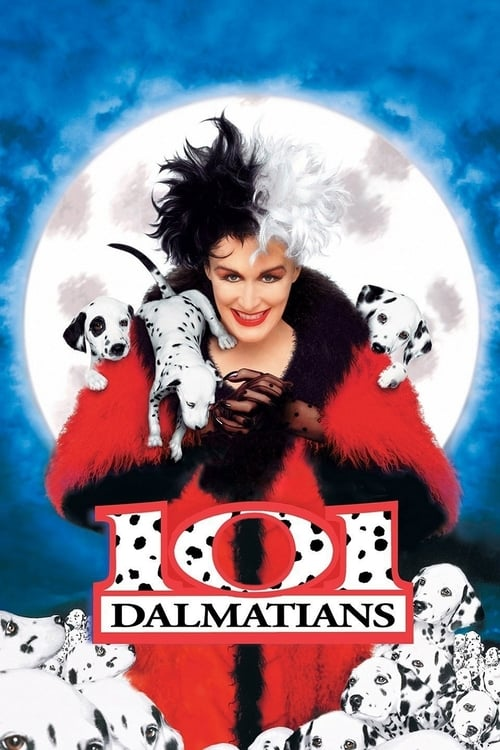

Stuart Little
The adventures of a heroic and debonair stalwart mouse named Stuart Little with human qualities, who faces some comic misadventures while living with a human family as their child.


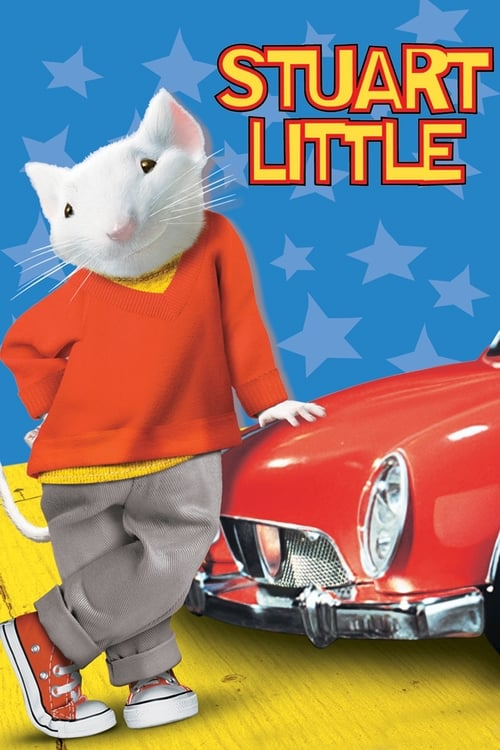

A Bug's Life
On behalf of "oppressed bugs everywhere," an inventive ant named Flik hires a troupe of warrior bugs to defend his bustling colony from a horde of freeloading grasshoppers led by the evil-minded Hopper.


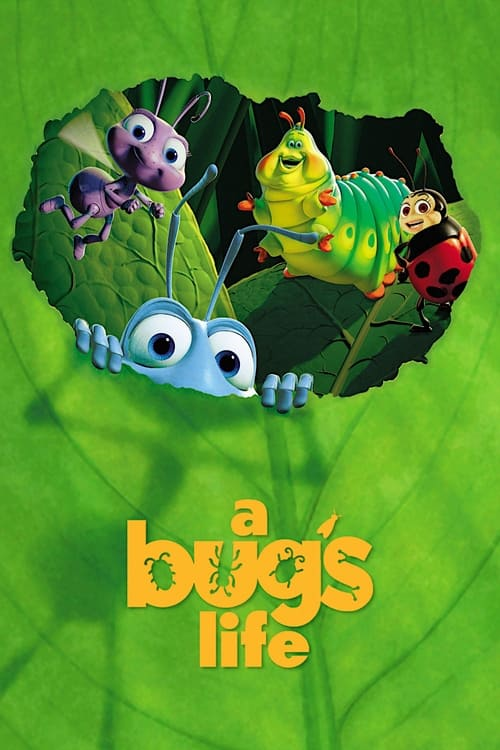

In [100]:
from IPython.display import Image

response = movies.query.near_text(
    query="Movie about lovable cute pets",
    target_vector="txt_vector",  # Search in the txt_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

Iron Man
After being held captive in an Afghan cave, billionaire engineer Tony Stark creates a unique weaponized suit of armor to fight evil.


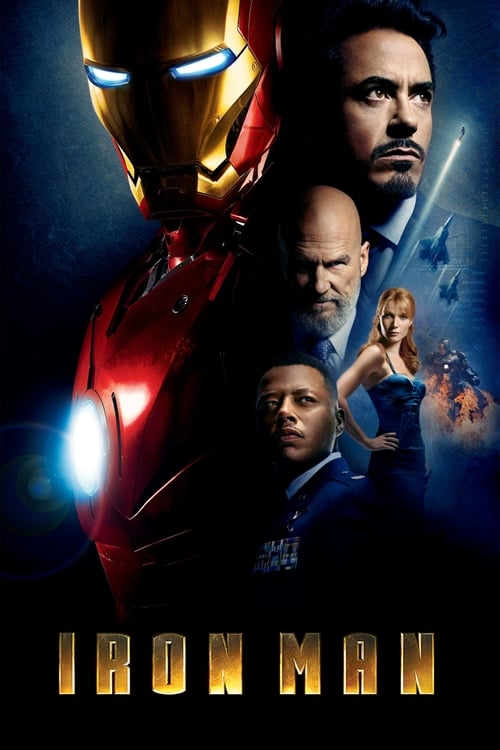

Incredibles 2
Elastigirl springs into action to save the day, while Mr. Incredible faces his greatest challenge yet – taking care of the problems of his three children.


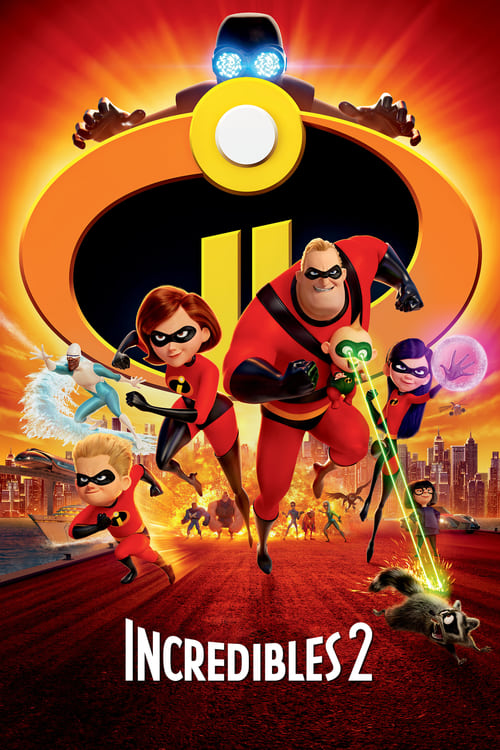

Shazam!
A boy is given the ability to become an adult superhero in times of need with a single magic word.


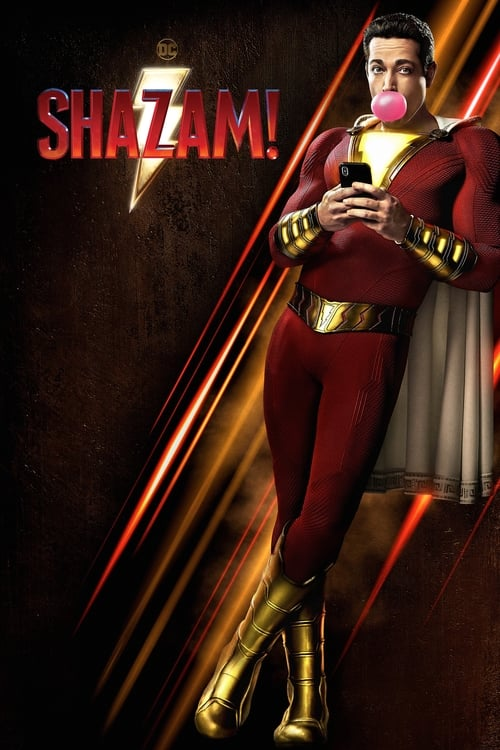

In [101]:
# Perform query
response = movies.query.near_text(
    query="Epic super hero",
    target_vector="txt_vector",  # Search in the txt_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

## Text-search through the posters vector space

Stuart Little
The adventures of a heroic and debonair stalwart mouse named Stuart Little with human qualities, who faces some comic misadventures while living with a human family as their child.


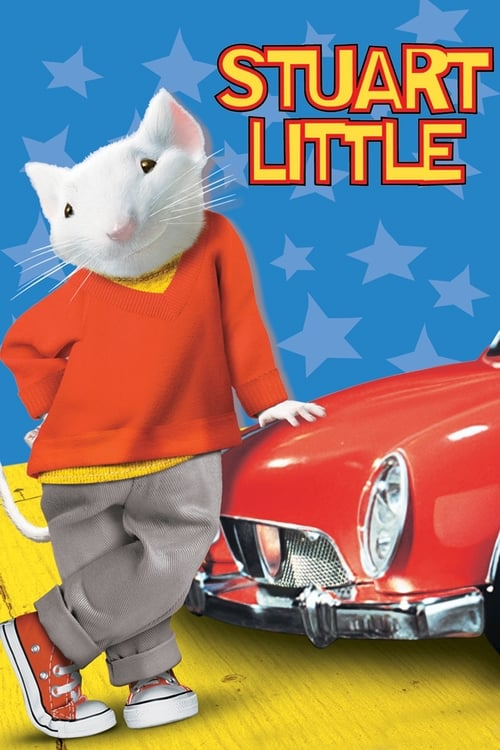

Beethoven
The Newton family live in their comfortable home, but there seems to something missing. This "hole" is filled by a small puppy, who walks into their home and their lives. Beethoven, as he is named, grows into a giant of a dog... a St Bernard. Doctor Varnick, the local vet has a secret and horrible sideline, which requires lots of dogs for experiments. Beethoven is on the bad doctor's list.


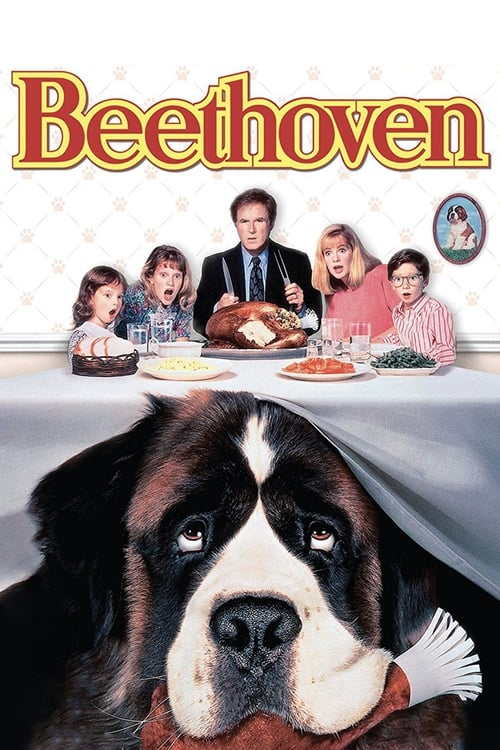

101 Dalmatians
An evil, high-fashion designer plots to steal Dalmatian puppies in order to make an extravagant fur coat, but instead creates an extravagant mess.


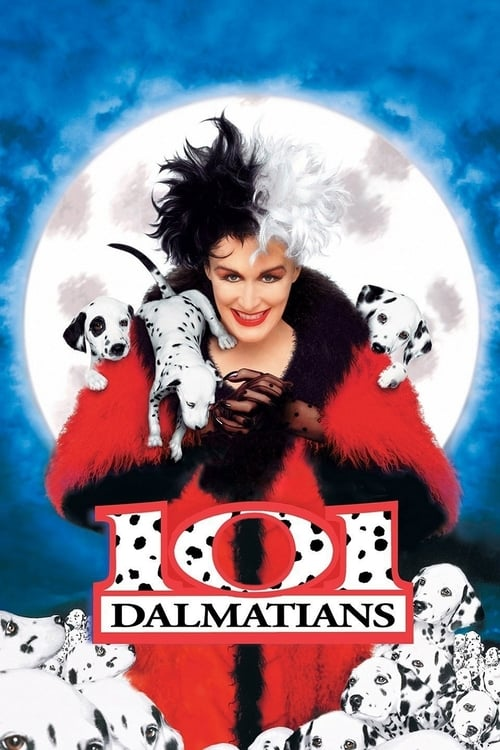

In [102]:
# Perform query
response = movies.query.near_text(
    query="Movie about lovable cute pets",
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

Shazam!
A boy is given the ability to become an adult superhero in times of need with a single magic word.


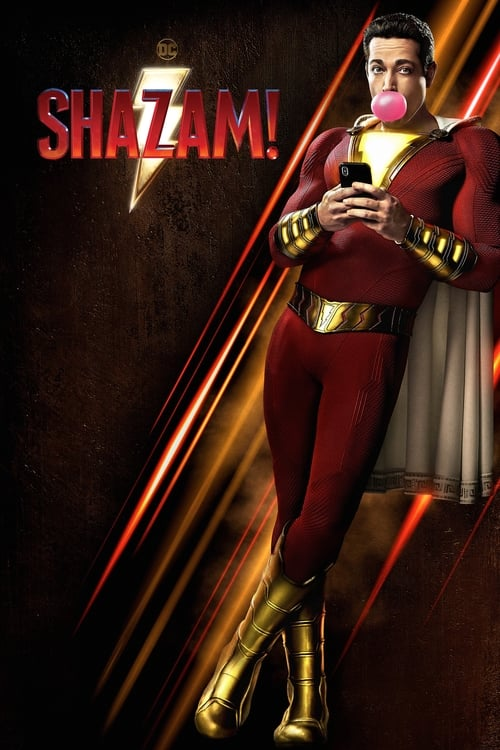

The Incredible Hulk
Scientist Bruce Banner scours the planet for an antidote to the unbridled force of rage within him: the Hulk. But when the military masterminds who dream of exploiting his powers force him back to civilization, he finds himself coming face to face with a new, deadly foe.


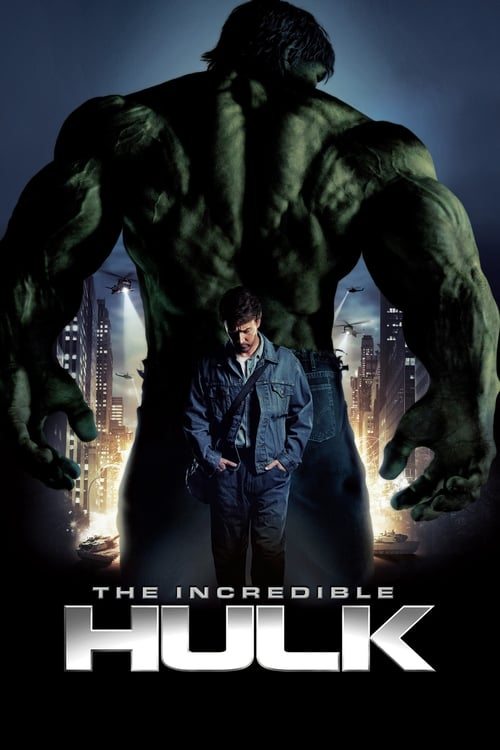

Incredibles 2
Elastigirl springs into action to save the day, while Mr. Incredible faces his greatest challenge yet – taking care of the problems of his three children.


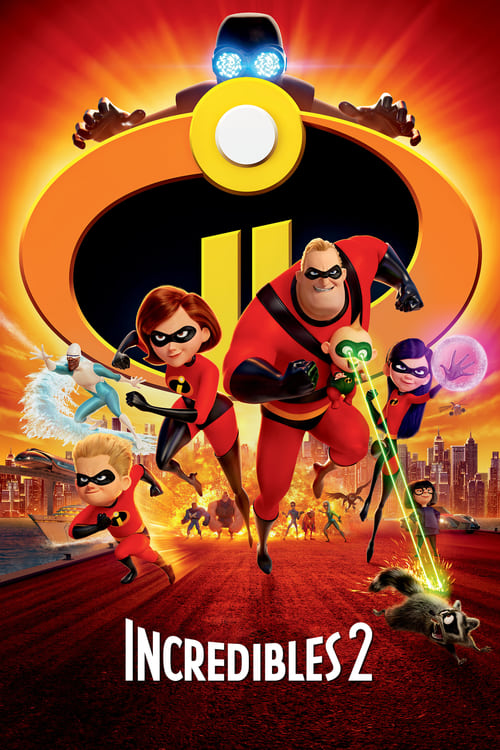

In [103]:
# Perform query
response = movies.query.near_text(
    query="Epic super hero",
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    print(item.properties["overview"])
    display(Image(item.properties["poster_path"], width=200))

## Image-search through the posters vector space

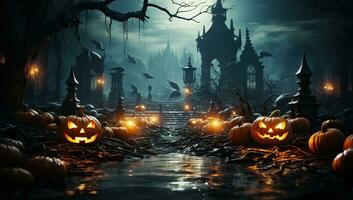

In [104]:
Image("../L6/test/spooky.jpg", width=300)

The Nightmare Before Christmas


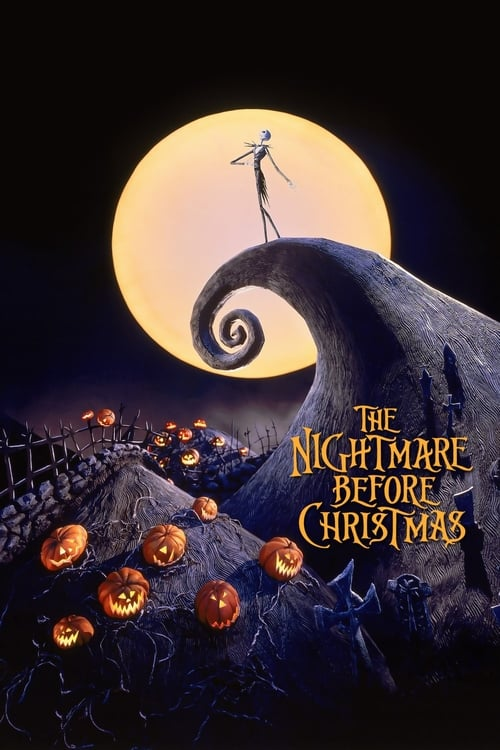

Hocus Pocus


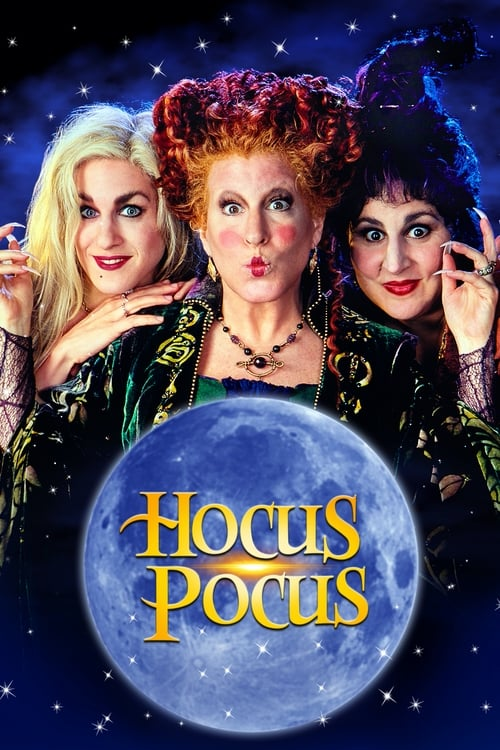

Scream


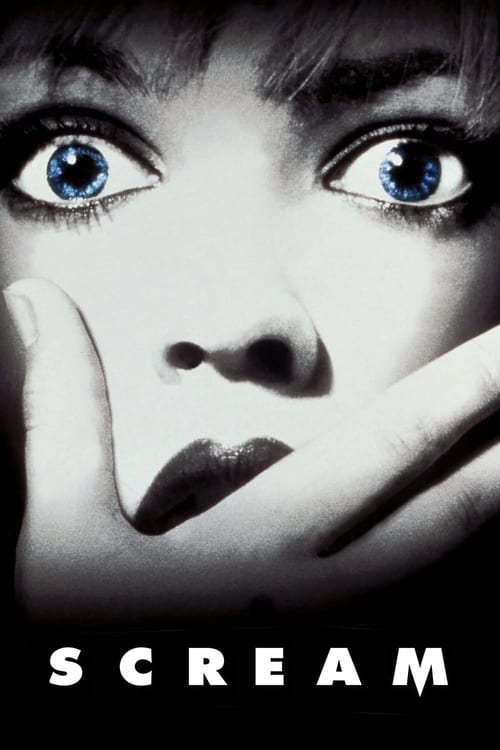

In [105]:
# Perform query
response = movies.query.near_image(
    near_image=toBase64("../L6/test/spooky.jpg"),
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    display(Image(item.properties["poster_path"], width=200))

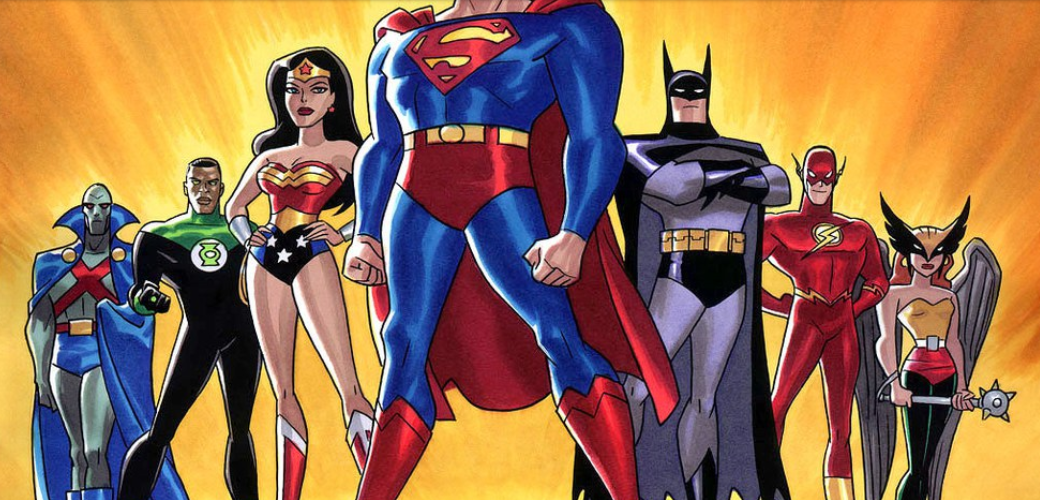

In [106]:
Image("../L6/test/superheroes.png", width=300)

Batman v Superman: Dawn of Justice


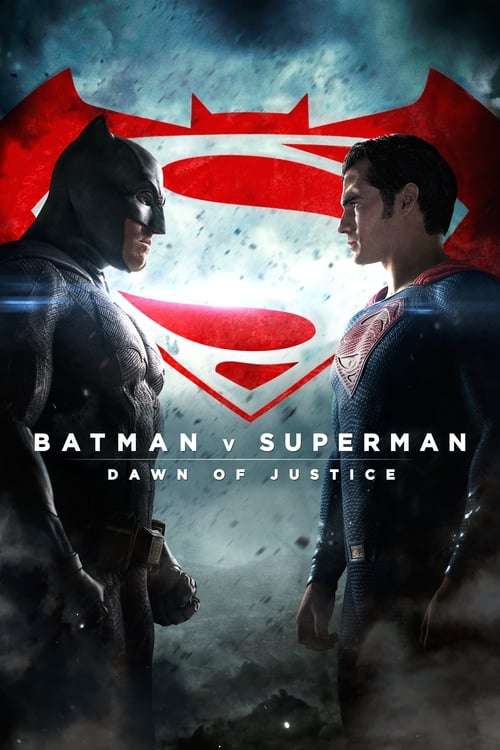

Iron Man


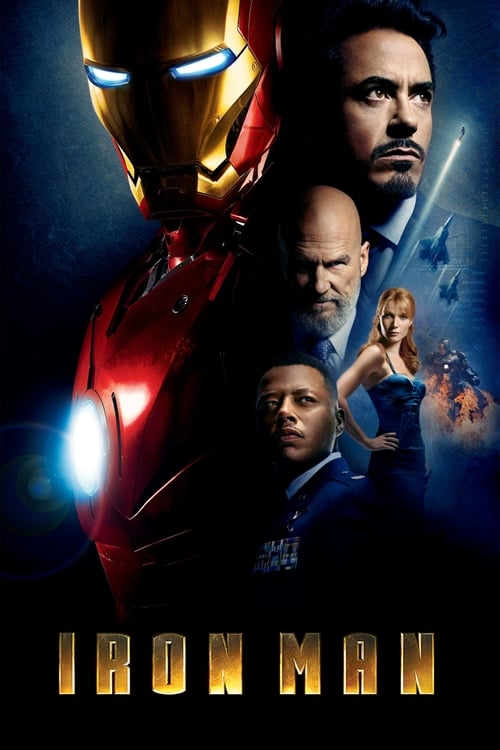

Ice Age


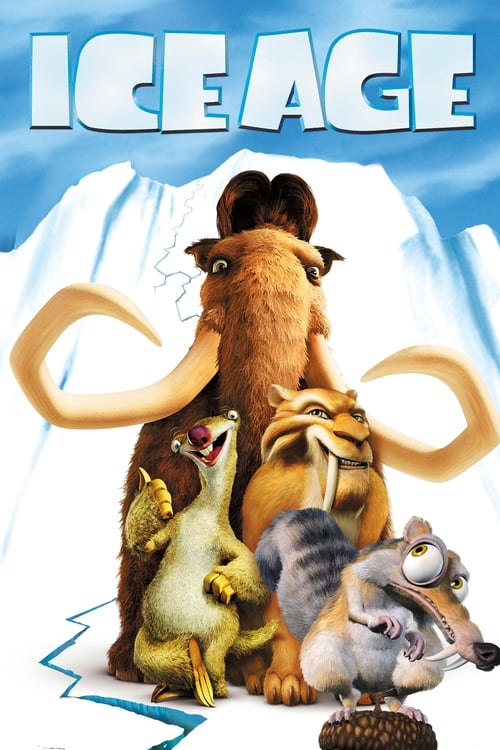

In [107]:
# Perform query
response = movies.query.near_image(
    near_image=toBase64("../L6/test/superheroes.png"),
    target_vector="poster_vector",  # Search in the poster_vector space
    limit=3,
)

# Inspect the response
for item in response.objects:
    print(item.properties["title"])
    display(Image(item.properties["poster_path"], width=200))

In [108]:
client.close()

{"action":"restapi_management","level":"info","msg":"Shutting down... ","time":"2025-02-12T14:56:05Z"}
{"action":"restapi_management","level":"info","msg":"Stopped serving weaviate at http://127.0.0.1:8079","time":"2025-02-12T14:56:05Z"}
{"action":"telemetry_push","level":"info","msg":"telemetry terminated","payload":"\u0026{MachineID:2a4e4f97-50fc-4bc3-8774-d0f1e53475a4 Type:TERMINATE Version:1.24.4 Modules:multi2vec-palm,text2vec-openai NumObjects:13629 OS:linux Arch:amd64}","time":"2025-02-12T14:56:05Z"}
